# Deep learning model
In this notebook, various deep learning classfiers will be trained to correctly classify spectrograms of gait data corresponding to one of three neuro-degenerative diseases or a healthy (control) subjects.

## Setup

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# had to change to tensorflow's keras implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

import tensorflow.keras.backend as K

%matplotlib inline

## Data
The dataset is imported from the corresponding directory. Each example consists of a $h \times w$ matrix, which corresponds to the spectrogram generated from the original signals.

The $m$ data points will be divided into a set for training and a set for validation (for hyperparameter tuning and model selection) following a 80/20 split.

In [10]:
rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/processed')

train_data = np.load(os.path.join(in_dir, 'train.npz'))
test_data = np.load(os.path.join(in_dir, 'test.npz'))

X_orig = train_data['X_train']
Y_orig = train_data['Y_train']
X_test_orig = test_data['X_test']
Y_test_orig = test_data['Y_test']

X_orig = X_orig.reshape(X_orig.shape[0], X_orig.shape[1],
                        X_orig.shape[2], 1)
X_test_orig = X_test_orig.reshape(X_test_orig.shape[0], X_test_orig.shape[1],
                        X_test_orig.shape[2], 1)

X_train_orig, X_dev_orig, Y_train_orig, Y_dev_orig = train_test_split(
    X_orig, Y_orig, random_state=1, test_size=0.20) # try splitting with stratify=Y_orig

In [11]:
# check dimensions
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_dev_orig.shape)
print(Y_dev_orig.shape)

(833, 11, 34, 1)
(833, 1)
(209, 11, 34, 1)
(209, 1)


In [12]:
# normalize inputs - maybe other way?? by batch?
X_train = (X_train_orig - X_train_orig.mean()) / X_train_orig.std()
X_dev = (X_dev_orig - X_dev_orig.mean()) / X_dev_orig.std()

Y_train = Y_train_orig
Y_dev = Y_dev_orig

In [13]:
X_train.max()

18.84877250600703

In [14]:
X_train.min()

-0.5645394700767908

In [15]:
X_dev.max()

25.255485009442605

In [16]:
X_dev.min()

-0.5597651387499272

## Classifiers

### One classifier per class
In order to reduce the number of parameters (weights) that will have to be trained, a classifier for each class will be trained, in a one-vs-all approach.

### Convolutional Neural Networks and other approaches
As a first approach, the candidate classifiers will be convolutional neural networks that input a 1-channel image (or matrix), which corresponds to the spectrogram calculated in previous steps.

Other possible approaches that could be taken could be
* Two-dimensional 2-channel Convolutional Neural Networks that input, as a single example, bothe left and right channels' spectrograms
* One-dimensional 1-channel Convolutional Neural Networks that input segments of the raw gait sensor signal (from either a left or a right foot sensor)
* One-dimensional 2-channel Convolutional Neural Networks that input both left and right channels' raw sensor data

*Note: The approaches described above could also benefit from Transfer Learning given the small size of the dataset*

Further, the data processing steps could be modified to acomodate for example:
* Finer segmentation of original records, which woulld generate more training examples
* Different parameters for time-frequency processing (spectrogram generation)

### Hyperparameters
Many hyperparameters can be considered in the selection of a model. For now, the main hyperparameters that will be explored are:

* The neural network **architecture**: which will be one of the 4 convolutional networks described above
* The **learning rate**, which usually has a great impact on the performance of the model
* The **dropout** rates, since the dataset is small and prone to overfitting. Some degree of Dropout regularization, which generally works better than L2 regularization, might be desirable.
* The number of **epochs** used in training

Other aspects such as initialization of weights, optimization algorithms or activation functions will be fixed, as explained below:

1. **Initialization**: weights will be initialized using He initialization and bias parameters will be initialized to zeros.
2. **Loss function**: the loss function will be the engative log-likelihood (which is the same as the binary cross-entropy).
3. **Optimization algorithm**: the weights will be updated using Adam.

### Proposed CNN architectures
Different Convolutional architectures will be trained. Given the small amount of data, which could easily lead to overfitting, these networks are particularly reduced in terms of number of parameters.

The architectures are described below:

* CNN_1A
* CNN_1B
* CNN_2A
* CNN_2B
* CNN_1C

| Architecture | Layer 1                                       | Layer 2        | Layer 3                                        | Layer 4        | Layer 5 | Layer 6 | Layer 7 |
|--------------|-----------------------------------------------|----------------|------------------------------------------------|----------------|---------|---------|---------|
| CNN_1A       | CONV (n=2; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=2; f=(3, 3); s=(2, 2); pad=(1, 1))  | MAXPOOL (3, 3) | Flatten | FC (12) | sigmoid |
| CNN_1B       | CONV (n=2; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=4; f=(3, 3); s=(2, 2); pad=(1, 1))  | MAXPOOL (3, 3) | Flatten | FC (20) | sigmoid |
| CNN_1C       | CONV (n=8; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=16; f=(3, 3); s=(2, 2); pad=(1, 1)) | MAXPOOL (3, 3) | Flatten | FC (96) | sigmoid |
| CNN_2A       | CONV (n=2; f=(2, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (2, 2) | CONV (n=2; f=(3, 3); s=(2, 2); pad=(0, 0))  | MAXPOOL (2, 2) | Flatten | FC (12) | sigmoid |
| CNN_2B       | CONV (n=2; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=4; f=(3, 3); s=(2, 2); pad=(0, 0))  | MAXPOOL (2, 2) | Flatten | FC (20) | sigmoid |

In [17]:
# these models dont seem to work well!
def get_CNN_1A(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3))) # last column being dropped
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(2, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def get_CNN_1B(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1B model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(4, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def get_CNN_2A(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_2A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (2, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Conv2D(2, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def get_CNN_2B(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_2A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (2, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Conv2D(4, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [18]:
def get_CNN_1C(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1C model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(8, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3))) # last column being dropped
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(16, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

A function to get the optimizer (Adam) with a given learning rate is also defined.

In [19]:
def get_optimizer(learning_rate):
    optimizer = optimizers.Adam(lr=learning_rate) # could use lr decay
    return optimizer

### Performance metrics

Various metrics will be evaluated when training each possible model, namely:

- Accuracy
- Precision
- Recall
- F1 Score

Precision, recall and F1-score depend on the **threshold** we set (at the moment the threshold is 0.5).

- It might interesting to calculate the ROC AUC

**What metric should we use to evaluate the models?**

Another option could be comparing the validation loss

**Problems:**
* For each classifier, data will be skewed (approximately 25% will be positives)
* We do not have at the moment a limit on the False Positive Rate: *how many (negative) cases can we allow to be classified with the disease?*
* We do not have at the moment a limit on the False Negative Rate: *how many (positive, with disease) cases can we allow to be classified as not having that disease?*
* Maybe it is better to have a false positive than a false negative?

In [20]:
# metrics need to be defined according to Keras' standards
# using the backend (tensorflow) tensor operations
def precision(y_true, y_pred):
    """Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (total_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    """
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

In [21]:
custom_metrics = ['accuracy', precision, recall, f1_score] # which one to use to evaluate model? accuracy or f1-score?

## Label redefinition
Since one classifier per class will be built, the original labels need to be converted to binary labels in each case

In [22]:
# redefinition of labels depending on each case
def redefine_labels(Y, target_class):
    """
    Transforms a K-labelled vector into a binary label vector. If Y[i] is equal to target_class
        then Y_binary[i] is 1. Otherwise, Y[i] is 0
    
    Arguments
    Y -- A (m, 1) NumPy array of labels ranging from 0 to (K - 1) with K being the number of classes
    target_class -- Integer indicating the target class
    
    Returns
    Y_binary -- A binary labelled (0 or 1) NumPy array of the same shape as Y
    """
    
    Y_binary = (Y == target_class).astype(int)
    return Y_binary

## Training and model evaluation

In [23]:
def plot_losses(losses):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.plot(np.arange(1, len(losses)+1), losses)
    return None

In [24]:
def train_model(hyperparameters, custom_metrics, X_train, Y_train, X_dev, Y_dev):
    
    # get hparams
    learning_rate = hyperparameters['lr']
    dropout_conv_rate = hyperparameters['dropout_conv']
    dropout_dense_rate = hyperparameters['dropout_dense']
    n_epochs = hyperparameters['epochs']
    get_model = hyperparameters['architecture'][1]

    # build model
    model = get_model(dropout_conv_rate, dropout_dense_rate)
    optimizer = get_optimizer(learning_rate)
    model.compile(optimizer=optimizer,
                 metrics=custom_metrics,
                 loss='binary_crossentropy')
    
    # train model
    history = model.fit(X_train, Y_train, batch_size=128, epochs=n_epochs,
              validation_data=(X_dev, Y_dev))
    
    # plot losses
    plot_losses(history.history['loss'])

    return model, history

In [25]:
# possible hyperparameters -> hyperparameter space
space = {
    'architecture': [get_CNN_1A, get_CNN_1B, get_CNN_2A, get_CNN_2B, get_CNN_1C],
    'lr': (0, 6), # 10 ** (-np.random.randint(0, 6))
    'dropout_conv': (0, 0.5),
    'dropout_dense': (0, 0.5),
    'epochs': [100, 200, 300, 400]
}

hyperparameters = dict()

### Save models and history dictionaries

In [26]:
import time
import pickle

def save_model_and_history(model, history, hyperparameters, name):
    rootdir = os.pardir
    out_dir = os.path.join(rootdir, 'trained_models')
    stamp = time.strftime('%Y%m%d-%H%M%S')
    
    # save model architecture and weigths
    model_path = os.path.join(out_dir, name + '.h5')
    model.save(model_path)
    
    # save history
    history_dict = history.history
    with open(os.path.join(out_dir, '_'.join([name, 'hist.pickle'])), 'wb') as handle:
        pickle.dump(history_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # save hyperparameters
    with open(os.path.join(out_dir, '_'.join([name, 'hparams.pickle'])), 'wb') as handle:
        pickle.dump(hyperparameters,  handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return None

### ALS classifier
Only two architectures will be compared below: architecture CNN_1A and CNN_1C, since architectures 1A, 1B, 2A and 2B gave similar (poor) performances.

In [39]:
disease = 'ALS'

In [40]:
Y_train_als = redefine_labels(Y_train, 1)
Y_dev_als = redefine_labels(Y_dev, 1)

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 910us/step - loss: 0.7042 - acc: 0.3313 - precision: 0.1964 - recall: 0.9266 - f1_score: 0.3194 - val_loss: 0.7033 - val_acc: 0.3684 - val_precision: 0.2512 - val_recall: 0.9764 - val_f1_score: 0.3993
Epoch 2/200
833/833 [==============================] - 0s 97us/step - loss: 0.7013 - acc: 0.3890 - precision: 0.2091 - recall: 0.9349 - f1_score: 0.3392 - val_loss: 0.7007 - val_acc: 0.4450 - val_precision: 0.2739 - val_recall: 0.9560 - val_f1_score: 0.4254
Epoch 3/200
833/833 [==============================] - 0s 113us/step - loss: 0.6985 - acc: 0.4346 - precision: 0.2205 - recall: 0.9041 - f1_score: 0.3522 - val_loss: 0.6981 - val_acc: 0.4737 - val_precision: 0.2792 - val_recall: 0.9121 - val_f1_score: 0.4270
Epoch 4/200
833/833 [==============================] - 0s 110us/step - loss: 0.6954 - acc: 0.4826 - precision: 0.2333 - recall: 0.8634 - f1_score: 0.3648 - val_loss: 0.6955 - val

Epoch 32/200
833/833 [==============================] - 0s 58us/step - loss: 0.6224 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6322 - val_acc: 0.7799 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 62us/step - loss: 0.6200 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6301 - val_acc: 0.7799 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 34/200
833/833 [==============================] - 0s 56us/step - loss: 0.6175 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6280 - val_acc: 0.7799 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 35/200
833/833 [==============================] - 0s 61us/step - loss: 0.6150 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sco

Epoch 61/200
833/833 [==============================] - 0s 101us/step - loss: 0.5447 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5670 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 62/200
833/833 [==============================] - 0s 110us/step - loss: 0.5416 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5648 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 63/200
833/833 [==============================] - 0s 107us/step - loss: 0.5389 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5625 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 64/200
833/833 [==============================] - 0s 108us/step - loss: 0.5361 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 90/200
833/833 [==============================] - 0s 102us/step - loss: 0.4832 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5223 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 91/200
833/833 [==============================] - 0s 101us/step - loss: 0.4818 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5214 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 92/200
833/833 [==============================] - 0s 105us/step - loss: 0.4804 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5205 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 93/200
833/833 [==============================] - 0s 106us/step - loss: 0.4789 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 119/200
833/833 [==============================] - 0s 106us/step - loss: 0.4335 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4939 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 120/200
833/833 [==============================] - 0s 110us/step - loss: 0.4329 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4934 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 121/200
833/833 [==============================] - 0s 104us/step - loss: 0.4322 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4927 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 122/200
833/833 [==============================] - 0s 101us/step - loss: 0.4316 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 

Epoch 148/200
833/833 [==============================] - 0s 113us/step - loss: 0.4167 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4781 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 149/200
833/833 [==============================] - 0s 121us/step - loss: 0.4160 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4775 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 150/200
833/833 [==============================] - 0s 118us/step - loss: 0.4154 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4767 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 151/200
833/833 [==============================] - 0s 121us/step - loss: 0.4147 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 

Epoch 177/200
833/833 [==============================] - 0s 103us/step - loss: 0.3879 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4461 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 178/200
833/833 [==============================] - 0s 125us/step - loss: 0.3871 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4454 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 179/200
833/833 [==============================] - 0s 81us/step - loss: 0.3863 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4446 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 180/200
833/833 [==============================] - 0s 63us/step - loss: 0.3855 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - 

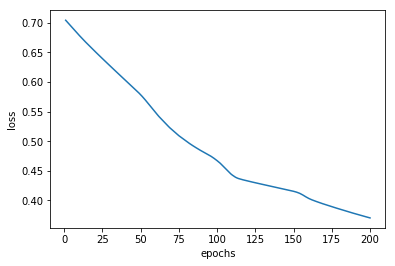

In [41]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 1ms/step - loss: 0.6897 - acc: 0.5510 - precision: 0.2671 - recall: 0.9098 - f1_score: 0.4064 - val_loss: 0.6748 - val_acc: 0.6555 - val_precision: 0.3484 - val_recall: 0.6923 - val_f1_score: 0.4632
Epoch 2/200
833/833 [==============================] - 0s 85us/step - loss: 0.6614 - acc: 0.7803 - precision: 0.4198 - recall: 0.4108 - f1_score: 0.3488 - val_loss: 0.6502 - val_acc: 0.7895 - val_precision: 0.3876 - val_recall: 0.0204 - val_f1_score: 0.0388
Epoch 3/200
833/833 [==============================] - 0s 87us/step - loss: 0.6337 - acc: 0.8307 - precision: 0.3073 - recall: 0.0105 - f1_score: 0.0203 - val_loss: 0.6277 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/200
833/833 [==============================] - 0s 87us/step - loss: 0.6092 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - va

Epoch 30/200
833/833 [==============================] - 0s 115us/step - loss: 0.3852 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4408 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 31/200
833/833 [==============================] - 0s 115us/step - loss: 0.3812 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4374 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 32/200
833/833 [==============================] - 0s 119us/step - loss: 0.3772 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4339 - val_acc: 0.7847 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 116us/step - loss: 0.3734 - acc: 0.8283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

833/833 [==============================] - 0s 121us/step - loss: 0.2826 - acc: 0.8679 - precision: 0.7043 - recall: 0.4094 - f1_score: 0.5093 - val_loss: 0.3506 - val_acc: 0.8134 - val_precision: 0.6841 - val_recall: 0.2606 - val_f1_score: 0.3664
Epoch 92/200
833/833 [==============================] - 0s 102us/step - loss: 0.2821 - acc: 0.8679 - precision: 0.6975 - recall: 0.4038 - f1_score: 0.5021 - val_loss: 0.3508 - val_acc: 0.8134 - val_precision: 0.6841 - val_recall: 0.2606 - val_f1_score: 0.3664
Epoch 93/200
833/833 [==============================] - 0s 121us/step - loss: 0.2814 - acc: 0.8679 - precision: 0.6897 - recall: 0.4221 - f1_score: 0.5207 - val_loss: 0.3514 - val_acc: 0.8182 - val_precision: 0.7087 - val_recall: 0.2606 - val_f1_score: 0.3727
Epoch 94/200
833/833 [==============================] - 0s 128us/step - loss: 0.2810 - acc: 0.8703 - precision: 0.7171 - recall: 0.4213 - f1_score: 0.5286 - val_loss: 0.3511 - val_acc: 0.8182 - val_precision: 0.7087 - val_recall: 0.2

833/833 [==============================] - 0s 121us/step - loss: 0.2550 - acc: 0.8848 - precision: 0.7606 - recall: 0.4817 - f1_score: 0.5849 - val_loss: 0.3132 - val_acc: 0.8182 - val_precision: 0.7087 - val_recall: 0.2606 - val_f1_score: 0.3727
Epoch 154/200
833/833 [==============================] - 0s 124us/step - loss: 0.2547 - acc: 0.8848 - precision: 0.7852 - recall: 0.4721 - f1_score: 0.5826 - val_loss: 0.3138 - val_acc: 0.8182 - val_precision: 0.7087 - val_recall: 0.2606 - val_f1_score: 0.3727
Epoch 155/200
833/833 [==============================] - 0s 125us/step - loss: 0.2542 - acc: 0.8884 - precision: 0.7726 - recall: 0.4823 - f1_score: 0.5872 - val_loss: 0.3120 - val_acc: 0.8182 - val_precision: 0.7087 - val_recall: 0.2606 - val_f1_score: 0.3727
Epoch 156/200
833/833 [==============================] - 0s 131us/step - loss: 0.2539 - acc: 0.8872 - precision: 0.7763 - recall: 0.4930 - f1_score: 0.5975 - val_loss: 0.3121 - val_acc: 0.8182 - val_precision: 0.7087 - val_recall: 

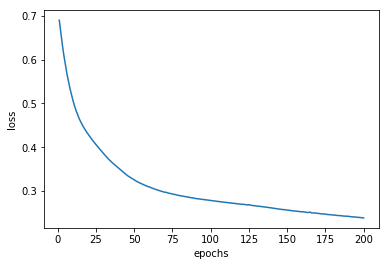

In [42]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1C = history.history

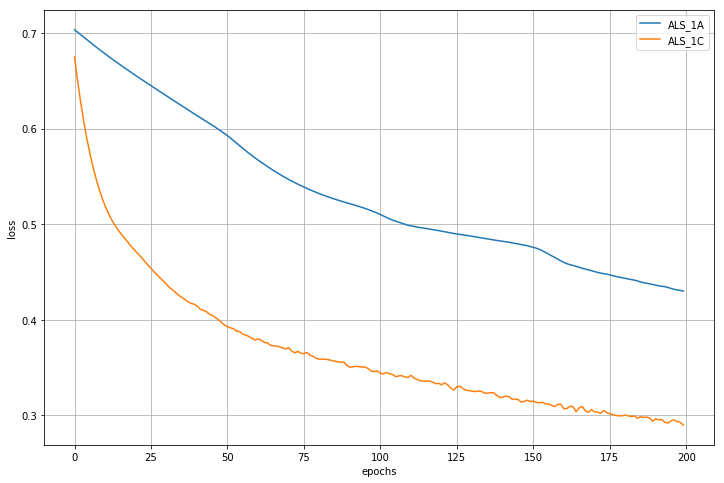

In [43]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

### Huntington's disease classifier

In [31]:
disease = 'hunt'

In [32]:
Y_train_hunt = redefine_labels(Y_train, 2)
Y_dev_hunt = redefine_labels(Y_dev, 2)

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 3s 4ms/step - loss: 0.7570 - acc: 0.3109 - precision: 0.3109 - recall: 1.0000 - f1_score: 0.4730 - val_loss: 0.7441 - val_acc: 0.3541 - val_precision: 0.3541 - val_recall: 1.0000 - val_f1_score: 0.5194
Epoch 2/200
833/833 [==============================] - 0s 116us/step - loss: 0.7543 - acc: 0.3109 - precision: 0.3109 - recall: 1.0000 - f1_score: 0.4731 - val_loss: 0.7418 - val_acc: 0.3541 - val_precision: 0.3541 - val_recall: 1.0000 - val_f1_score: 0.5194
Epoch 3/200
833/833 [==============================] - 0s 88us/step - loss: 0.7516 - acc: 0.3109 - precision: 0.3109 - recall: 1.0000 - f1_score: 0.4712 - val_loss: 0.7396 - val_acc: 0.3541 - val_precision: 0.3541 - val_recall: 1.0000 - val_f1_score: 0.5194
Epoch 4/200
833/833 [==============================] - 0s 59us/step - loss: 0.7487 - acc: 0.3109 - precision: 0.3109 - recall: 1.0000 - f1_score: 0.4734 - val_loss: 0.7375 - val_ac

833/833 [==============================] - 0s 77us/step - loss: 0.6924 - acc: 0.5198 - precision: 0.3612 - recall: 0.7130 - f1_score: 0.4785 - val_loss: 0.6933 - val_acc: 0.4928 - val_precision: 0.3621 - val_recall: 0.5764 - val_f1_score: 0.4408
Epoch 33/200
833/833 [==============================] - 0s 102us/step - loss: 0.6910 - acc: 0.5462 - precision: 0.3671 - recall: 0.6352 - f1_score: 0.4637 - val_loss: 0.6922 - val_acc: 0.5407 - val_precision: 0.3822 - val_recall: 0.4824 - val_f1_score: 0.4232
Epoch 34/200
833/833 [==============================] - 0s 99us/step - loss: 0.6897 - acc: 0.5774 - precision: 0.3852 - recall: 0.5684 - f1_score: 0.4529 - val_loss: 0.6911 - val_acc: 0.5981 - val_precision: 0.4327 - val_recall: 0.4530 - val_f1_score: 0.4400
Epoch 35/200
833/833 [==============================] - 0s 100us/step - loss: 0.6883 - acc: 0.6194 - precision: 0.4093 - recall: 0.4851 - f1_score: 0.4412 - val_loss: 0.6901 - val_acc: 0.5933 - val_precision: 0.4238 - val_recall: 0.411

833/833 [==============================] - 0s 102us/step - loss: 0.6606 - acc: 0.6915 - precision: 0.4519 - recall: 0.0246 - f1_score: 0.0461 - val_loss: 0.6702 - val_acc: 0.6411 - val_precision: 0.6124 - val_recall: 0.0118 - val_f1_score: 0.0231
Epoch 64/200
833/833 [==============================] - 0s 103us/step - loss: 0.6596 - acc: 0.6903 - precision: 0.5378 - recall: 0.0227 - f1_score: 0.0433 - val_loss: 0.6696 - val_acc: 0.6411 - val_precision: 0.6124 - val_recall: 0.0118 - val_f1_score: 0.0231
Epoch 65/200
833/833 [==============================] - 0s 107us/step - loss: 0.6588 - acc: 0.6903 - precision: 0.4610 - recall: 0.0230 - f1_score: 0.0435 - val_loss: 0.6691 - val_acc: 0.6411 - val_precision: 0.6124 - val_recall: 0.0118 - val_f1_score: 0.0231
Epoch 66/200
833/833 [==============================] - 0s 92us/step - loss: 0.6580 - acc: 0.6903 - precision: 0.4366 - recall: 0.0222 - f1_score: 0.0423 - val_loss: 0.6686 - val_acc: 0.6411 - val_precision: 0.6124 - val_recall: 0.01

833/833 [==============================] - 0s 97us/step - loss: 0.6384 - acc: 0.6855 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6564 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 94/200
833/833 [==============================] - 0s 94us/step - loss: 0.6378 - acc: 0.6855 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6561 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 95/200
833/833 [==============================] - 0s 96us/step - loss: 0.6372 - acc: 0.6855 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6557 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 96/200
833/833 [==============================] - 0s 104us/step - loss: 0.6366 - acc: 0.6855 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+

Epoch 122/200
833/833 [==============================] - 0s 101us/step - loss: 0.6243 - acc: 0.6867 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6502 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 123/200
833/833 [==============================] - 0s 102us/step - loss: 0.6240 - acc: 0.6867 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6501 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 124/200
833/833 [==============================] - 0s 103us/step - loss: 0.6236 - acc: 0.6867 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6500 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 125/200
833/833 [==============================] - 0s 102us/step - loss: 0.6233 - acc: 0.6867 - precision: 0.0000e+00 - recall: 0.0000e+00 

Epoch 151/200
833/833 [==============================] - 0s 98us/step - loss: 0.6170 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6491 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 152/200
833/833 [==============================] - 0s 95us/step - loss: 0.6169 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6491 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 153/200
833/833 [==============================] - 0s 104us/step - loss: 0.6167 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6491 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 154/200
833/833 [==============================] - 0s 97us/step - loss: 0.6165 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f

Epoch 180/200
833/833 [==============================] - 0s 100us/step - loss: 0.6124 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6482 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 181/200
833/833 [==============================] - 0s 94us/step - loss: 0.6123 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6481 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 182/200
833/833 [==============================] - 0s 100us/step - loss: 0.6121 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6481 - val_acc: 0.6411 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 183/200
833/833 [==============================] - 0s 96us/step - loss: 0.6120 - acc: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - 

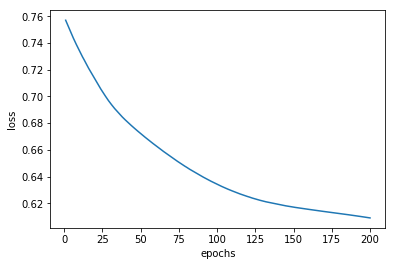

In [33]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_hunt, X_dev, Y_dev_hunt)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 691us/step - loss: 0.6948 - acc: 0.4538 - precision: 0.3165 - recall: 0.5893 - f1_score: 0.3901 - val_loss: 0.6855 - val_acc: 0.6699 - val_precision: 0.5778 - val_recall: 0.2530 - val_f1_score: 0.3489
Epoch 2/200
833/833 [==============================] - 0s 79us/step - loss: 0.6802 - acc: 0.6699 - precision: 0.4938 - recall: 0.0856 - f1_score: 0.1279 - val_loss: 0.6753 - val_acc: 0.6651 - val_precision: 1.0000 - val_recall: 0.0529 - val_f1_score: 0.1005
Epoch 3/200
833/833 [==============================] - 0s 81us/step - loss: 0.6673 - acc: 0.6879 - precision: 0.0768 - recall: 0.0037 - f1_score: 0.0071 - val_loss: 0.6668 - val_acc: 0.6459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/200
833/833 [==============================] - 0s 100us/step - loss: 0.6557 - acc: 0.6891 - precision: 0.1537 - recall: 0.0035 - f1_score: 0.0068 - val_loss: 0

833/833 [==============================] - 0s 103us/step - loss: 0.6092 - acc: 0.6891 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6409 - val_acc: 0.6459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 31/200
833/833 [==============================] - 0s 95us/step - loss: 0.6083 - acc: 0.6891 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6404 - val_acc: 0.6459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 32/200
833/833 [==============================] - 0s 91us/step - loss: 0.6076 - acc: 0.6891 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6401 - val_acc: 0.6459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 100us/step - loss: 0.6070 - acc: 0.6891 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e

833/833 [==============================] - 0s 111us/step - loss: 0.5806 - acc: 0.7203 - precision: 1.0000 - recall: 0.0999 - f1_score: 0.1766 - val_loss: 0.6121 - val_acc: 0.6651 - val_precision: 1.0000 - val_recall: 0.0588 - val_f1_score: 0.1100
Epoch 61/200
833/833 [==============================] - 0s 93us/step - loss: 0.5789 - acc: 0.7203 - precision: 1.0000 - recall: 0.1020 - f1_score: 0.1830 - val_loss: 0.6106 - val_acc: 0.6699 - val_precision: 1.0000 - val_recall: 0.0706 - val_f1_score: 0.1314
Epoch 62/200
833/833 [==============================] - 0s 104us/step - loss: 0.5775 - acc: 0.7203 - precision: 1.0000 - recall: 0.0979 - f1_score: 0.1774 - val_loss: 0.6090 - val_acc: 0.6699 - val_precision: 1.0000 - val_recall: 0.0706 - val_f1_score: 0.1314
Epoch 63/200
833/833 [==============================] - 0s 99us/step - loss: 0.5761 - acc: 0.7227 - precision: 1.0000 - recall: 0.1087 - f1_score: 0.1941 - val_loss: 0.6065 - val_acc: 0.6699 - val_precision: 0.8775 - val_recall: 0.082

Epoch 92/200
833/833 [==============================] - 0s 90us/step - loss: 0.5381 - acc: 0.7455 - precision: 0.8364 - recall: 0.2239 - f1_score: 0.3479 - val_loss: 0.5687 - val_acc: 0.6938 - val_precision: 0.7766 - val_recall: 0.1648 - val_f1_score: 0.2693
Epoch 93/200
833/833 [==============================] - 0s 96us/step - loss: 0.5368 - acc: 0.7443 - precision: 0.8249 - recall: 0.2200 - f1_score: 0.3460 - val_loss: 0.5670 - val_acc: 0.6938 - val_precision: 0.7766 - val_recall: 0.1648 - val_f1_score: 0.2693
Epoch 94/200
833/833 [==============================] - 0s 98us/step - loss: 0.5356 - acc: 0.7455 - precision: 0.8305 - recall: 0.2310 - f1_score: 0.3582 - val_loss: 0.5650 - val_acc: 0.6986 - val_precision: 0.7833 - val_recall: 0.1766 - val_f1_score: 0.2847
Epoch 95/200
833/833 [==============================] - 0s 100us/step - loss: 0.5344 - acc: 0.7455 - precision: 0.8079 - recall: 0.2336 - f1_score: 0.3575 - val_loss: 0.5640 - val_acc: 0.6986 - val_precision: 0.7833 - val_r

833/833 [==============================] - 0s 100us/step - loss: 0.5047 - acc: 0.7575 - precision: 0.7872 - recall: 0.2929 - f1_score: 0.4258 - val_loss: 0.5326 - val_acc: 0.7129 - val_precision: 0.7483 - val_recall: 0.2413 - val_f1_score: 0.3622
Epoch 124/200
833/833 [==============================] - 0s 94us/step - loss: 0.5038 - acc: 0.7575 - precision: 0.8050 - recall: 0.2920 - f1_score: 0.4242 - val_loss: 0.5330 - val_acc: 0.7129 - val_precision: 0.8010 - val_recall: 0.2295 - val_f1_score: 0.3519
Epoch 125/200
833/833 [==============================] - 0s 103us/step - loss: 0.5042 - acc: 0.7587 - precision: 0.8263 - recall: 0.2822 - f1_score: 0.4120 - val_loss: 0.5335 - val_acc: 0.7177 - val_precision: 0.8979 - val_recall: 0.2295 - val_f1_score: 0.3555
Epoch 126/200
833/833 [==============================] - 0s 106us/step - loss: 0.5016 - acc: 0.7575 - precision: 0.7946 - recall: 0.2899 - f1_score: 0.4174 - val_loss: 0.5260 - val_acc: 0.7225 - val_precision: 0.7595 - val_recall: 0

833/833 [==============================] - 0s 91us/step - loss: 0.4793 - acc: 0.7791 - precision: 0.8201 - recall: 0.3678 - f1_score: 0.5039 - val_loss: 0.5007 - val_acc: 0.7464 - val_precision: 0.8426 - val_recall: 0.3413 - val_f1_score: 0.4827
Epoch 155/200
833/833 [==============================] - 0s 99us/step - loss: 0.4799 - acc: 0.7743 - precision: 0.8387 - recall: 0.3512 - f1_score: 0.4869 - val_loss: 0.5070 - val_acc: 0.7368 - val_precision: 0.9081 - val_recall: 0.2883 - val_f1_score: 0.4327
Epoch 156/200
833/833 [==============================] - 0s 104us/step - loss: 0.4777 - acc: 0.7719 - precision: 0.8129 - recall: 0.3547 - f1_score: 0.4838 - val_loss: 0.4987 - val_acc: 0.7560 - val_precision: 0.8536 - val_recall: 0.3706 - val_f1_score: 0.5149
Epoch 157/200
833/833 [==============================] - 0s 97us/step - loss: 0.4766 - acc: 0.7779 - precision: 0.8068 - recall: 0.3759 - f1_score: 0.5104 - val_loss: 0.5018 - val_acc: 0.7368 - val_precision: 0.8333 - val_recall: 0.3

833/833 [==============================] - 0s 92us/step - loss: 0.4581 - acc: 0.7851 - precision: 0.8358 - recall: 0.3882 - f1_score: 0.5279 - val_loss: 0.4861 - val_acc: 0.7656 - val_precision: 0.9201 - val_recall: 0.3765 - val_f1_score: 0.5333
Epoch 186/200
833/833 [==============================] - 0s 99us/step - loss: 0.4570 - acc: 0.7887 - precision: 0.8260 - recall: 0.4074 - f1_score: 0.5379 - val_loss: 0.4784 - val_acc: 0.7703 - val_precision: 0.8847 - val_recall: 0.4059 - val_f1_score: 0.5565
Epoch 187/200
833/833 [==============================] - 0s 103us/step - loss: 0.4566 - acc: 0.7911 - precision: 0.7921 - recall: 0.4414 - f1_score: 0.5648 - val_loss: 0.4786 - val_acc: 0.7703 - val_precision: 0.8847 - val_recall: 0.4059 - val_f1_score: 0.5565
Epoch 188/200
833/833 [==============================] - 0s 94us/step - loss: 0.4560 - acc: 0.7923 - precision: 0.8287 - recall: 0.4270 - f1_score: 0.5575 - val_loss: 0.4846 - val_acc: 0.7656 - val_precision: 0.9201 - val_recall: 0.3

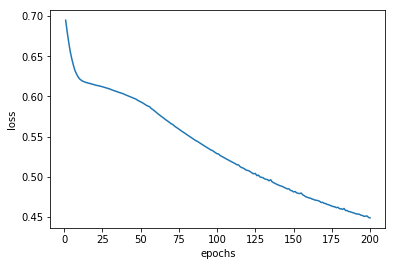

In [34]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_hunt, X_dev, Y_dev_hunt)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1C = history.history

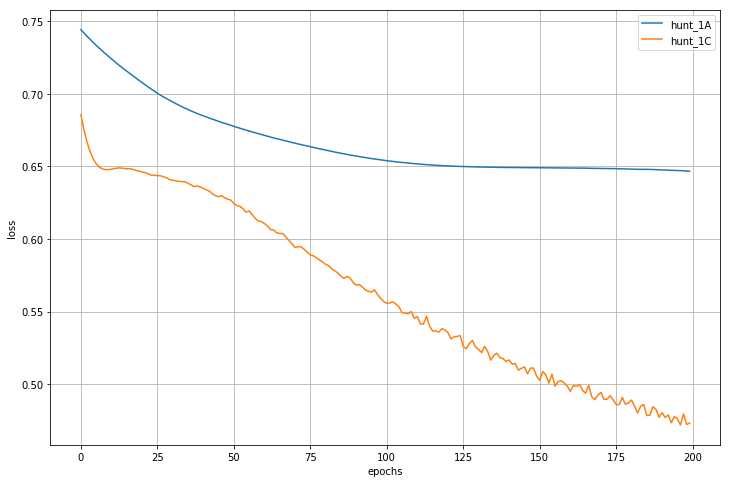

In [35]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

### Parkinson's disease classifier

In [41]:
disease = 'park'

In [42]:
Y_train_park = redefine_labels(Y_train, 3)
Y_dev_park = redefine_labels(Y_dev, 3)

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 776us/step - loss: 0.7291 - acc: 0.2533 - precision: 0.2533 - recall: 1.0000 - f1_score: 0.4025 - val_loss: 0.7356 - val_acc: 0.1914 - val_precision: 0.1914 - val_recall: 1.0000 - val_f1_score: 0.3206
Epoch 2/200
833/833 [==============================] - 0s 102us/step - loss: 0.7274 - acc: 0.2533 - precision: 0.2533 - recall: 1.0000 - f1_score: 0.4030 - val_loss: 0.7334 - val_acc: 0.1914 - val_precision: 0.1914 - val_recall: 1.0000 - val_f1_score: 0.3206
Epoch 3/200
833/833 [==============================] - 0s 118us/step - loss: 0.7256 - acc: 0.2533 - precision: 0.2533 - recall: 1.0000 - f1_score: 0.4010 - val_loss: 0.7313 - val_acc: 0.1914 - val_precision: 0.1914 - val_recall: 1.0000 - val_f1_score: 0.3206
Epoch 4/200
833/833 [==============================] - 0s 110us/step - loss: 0.7238 - acc: 0.2533 - precision: 0.2533 - recall: 1.0000 - f1_score: 0.4030 - val_loss: 0.7291 - va

833/833 [==============================] - 0s 49us/step - loss: 0.6857 - acc: 0.6531 - precision: 0.1699 - recall: 0.0905 - f1_score: 0.1170 - val_loss: 0.6823 - val_acc: 0.7464 - val_precision: 0.2382 - val_recall: 0.1481 - val_f1_score: 0.1825
Epoch 33/200
833/833 [==============================] - 0s 113us/step - loss: 0.6844 - acc: 0.6687 - precision: 0.1567 - recall: 0.0640 - f1_score: 0.0895 - val_loss: 0.6806 - val_acc: 0.7656 - val_precision: 0.2699 - val_recall: 0.1266 - val_f1_score: 0.1722
Epoch 34/200
833/833 [==============================] - 0s 125us/step - loss: 0.6831 - acc: 0.6831 - precision: 0.1446 - recall: 0.0536 - f1_score: 0.0766 - val_loss: 0.6789 - val_acc: 0.7799 - val_precision: 0.3149 - val_recall: 0.1266 - val_f1_score: 0.1805
Epoch 35/200
833/833 [==============================] - 0s 120us/step - loss: 0.6818 - acc: 0.6975 - precision: 0.1651 - recall: 0.0475 - f1_score: 0.0726 - val_loss: 0.6772 - val_acc: 0.7751 - val_precision: 0.2306 - val_recall: 0.07

Epoch 62/200
833/833 [==============================] - 0s 98us/step - loss: 0.6416 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6255 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 63/200
833/833 [==============================] - 0s 105us/step - loss: 0.6402 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6236 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 64/200
833/833 [==============================] - 0s 107us/step - loss: 0.6387 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6216 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 65/200
833/833 [==============================] - 0s 102us/step - loss: 0.6373 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_

Epoch 91/200
833/833 [==============================] - 0s 61us/step - loss: 0.5990 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5660 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 92/200
833/833 [==============================] - 0s 66us/step - loss: 0.5976 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5639 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 93/200
833/833 [==============================] - 0s 73us/step - loss: 0.5962 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5618 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 94/200
833/833 [==============================] - 0s 63us/step - loss: 0.5949 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sco

Epoch 120/200
833/833 [==============================] - 0s 91us/step - loss: 0.5710 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5171 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 121/200
833/833 [==============================] - 0s 90us/step - loss: 0.5706 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5161 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 122/200
833/833 [==============================] - 0s 96us/step - loss: 0.5703 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5151 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 123/200
833/833 [==============================] - 0s 89us/step - loss: 0.5698 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 149/200
833/833 [==============================] - 0s 86us/step - loss: 0.5665 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5024 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 150/200
833/833 [==============================] - 0s 66us/step - loss: 0.5665 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5023 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 151/200
833/833 [==============================] - 0s 64us/step - loss: 0.5665 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5022 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 152/200
833/833 [==============================] - 0s 63us/step - loss: 0.5664 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 178/200
833/833 [==============================] - 0s 99us/step - loss: 0.5661 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5002 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 179/200
833/833 [==============================] - 0s 101us/step - loss: 0.5661 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5002 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 180/200
833/833 [==============================] - 0s 110us/step - loss: 0.5660 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5001 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 181/200
833/833 [==============================] - 0s 115us/step - loss: 0.5660 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 -

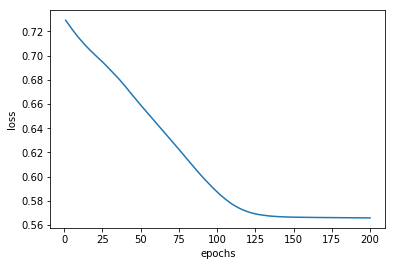

In [43]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_park, X_dev, Y_dev_park)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 1ms/step - loss: 0.7310 - acc: 0.3001 - precision: 0.2592 - recall: 0.9495 - f1_score: 0.4057 - val_loss: 0.7147 - val_acc: 0.3541 - val_precision: 0.2155 - val_recall: 0.9013 - val_f1_score: 0.3470
Epoch 2/200
833/833 [==============================] - 0s 44us/step - loss: 0.6954 - acc: 0.4454 - precision: 0.2506 - recall: 0.6158 - f1_score: 0.3500 - val_loss: 0.6722 - val_acc: 0.6603 - val_precision: 0.1837 - val_recall: 0.2379 - val_f1_score: 0.2068
Epoch 3/200
833/833 [==============================] - 0s 43us/step - loss: 0.6636 - acc: 0.7047 - precision: 0.2770 - recall: 0.1432 - f1_score: 0.1712 - val_loss: 0.6357 - val_acc: 0.7943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/200
833/833 [==============================] - 0s 49us/step - loss: 0.6379 - acc: 0.7479 - precision: 0.1537 - recall: 0.0040 - f1_score: 0.0079 - val_loss: 0.60

833/833 [==============================] - 0s 91us/step - loss: 0.5575 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4892 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 31/200
833/833 [==============================] - 0s 92us/step - loss: 0.5573 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4893 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 32/200
833/833 [==============================] - 0s 96us/step - loss: 0.5570 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4897 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 93us/step - loss: 0.5567 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+0

Epoch 59/200
833/833 [==============================] - 0s 105us/step - loss: 0.5487 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4855 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 60/200
833/833 [==============================] - 0s 102us/step - loss: 0.5483 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4853 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 61/200
833/833 [==============================] - 0s 103us/step - loss: 0.5479 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4844 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 62/200
833/833 [==============================] - 0s 101us/step - loss: 0.5475 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 88/200
833/833 [==============================] - 0s 108us/step - loss: 0.5348 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4748 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 89/200
833/833 [==============================] - 0s 93us/step - loss: 0.5342 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4748 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 90/200
833/833 [==============================] - 0s 91us/step - loss: 0.5337 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4739 - val_acc: 0.8086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 91/200
833/833 [==============================] - 0s 88us/step - loss: 0.5331 - acc: 0.7467 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sc

Epoch 118/200
833/833 [==============================] - 0s 90us/step - loss: 0.5162 - acc: 0.7551 - precision: 0.7567 - recall: 0.0409 - f1_score: 0.0763 - val_loss: 0.4663 - val_acc: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 119/200
833/833 [==============================] - 0s 88us/step - loss: 0.5155 - acc: 0.7551 - precision: 0.6915 - recall: 0.0405 - f1_score: 0.0755 - val_loss: 0.4650 - val_acc: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 120/200
833/833 [==============================] - 0s 87us/step - loss: 0.5150 - acc: 0.7551 - precision: 0.6659 - recall: 0.0437 - f1_score: 0.0815 - val_loss: 0.4618 - val_acc: 0.7990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 121/200
833/833 [==============================] - 0s 101us/step - loss: 0.5143 - acc: 0.7539 - precision: 0.7439 - recall: 0.0412 - f1_score: 0.0774 - val_loss: 0.4612 - val_acc

833/833 [==============================] - 0s 91us/step - loss: 0.4986 - acc: 0.7599 - precision: 0.7695 - recall: 0.0781 - f1_score: 0.1378 - val_loss: 0.4555 - val_acc: 0.7943 - val_precision: 0.3163 - val_recall: 0.0494 - val_f1_score: 0.0841
Epoch 150/200
833/833 [==============================] - 0s 97us/step - loss: 0.4986 - acc: 0.7599 - precision: 0.7268 - recall: 0.0772 - f1_score: 0.1331 - val_loss: 0.4523 - val_acc: 0.7943 - val_precision: 0.3163 - val_recall: 0.0494 - val_f1_score: 0.0841
Epoch 151/200
833/833 [==============================] - 0s 91us/step - loss: 0.4983 - acc: 0.7599 - precision: 0.7459 - recall: 0.0831 - f1_score: 0.1465 - val_loss: 0.4559 - val_acc: 0.7895 - val_precision: 0.2775 - val_recall: 0.0709 - val_f1_score: 0.1128
Epoch 152/200
833/833 [==============================] - 0s 92us/step - loss: 0.4972 - acc: 0.7611 - precision: 0.7244 - recall: 0.0902 - f1_score: 0.1546 - val_loss: 0.4541 - val_acc: 0.7943 - val_precision: 0.3163 - val_recall: 0.04

833/833 [==============================] - 0s 87us/step - loss: 0.4860 - acc: 0.7791 - precision: 0.7666 - recall: 0.1697 - f1_score: 0.2726 - val_loss: 0.4526 - val_acc: 0.8182 - val_precision: 0.5617 - val_recall: 0.2253 - val_f1_score: 0.3216
Epoch 181/200
833/833 [==============================] - 0s 88us/step - loss: 0.4857 - acc: 0.7803 - precision: 0.7971 - recall: 0.1902 - f1_score: 0.3034 - val_loss: 0.4519 - val_acc: 0.8182 - val_precision: 0.5617 - val_recall: 0.2253 - val_f1_score: 0.3216
Epoch 182/200
833/833 [==============================] - 0s 86us/step - loss: 0.4850 - acc: 0.7779 - precision: 0.8022 - recall: 0.1601 - f1_score: 0.2650 - val_loss: 0.4486 - val_acc: 0.8134 - val_precision: 0.5277 - val_recall: 0.1975 - val_f1_score: 0.2873
Epoch 183/200
833/833 [==============================] - 0s 92us/step - loss: 0.4849 - acc: 0.7779 - precision: 0.8359 - recall: 0.1646 - f1_score: 0.2700 - val_loss: 0.4496 - val_acc: 0.8134 - val_precision: 0.5277 - val_recall: 0.19

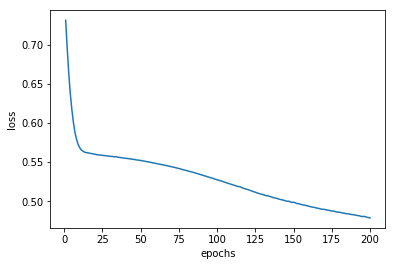

In [44]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_park, X_dev, Y_dev_park)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1C = history.history

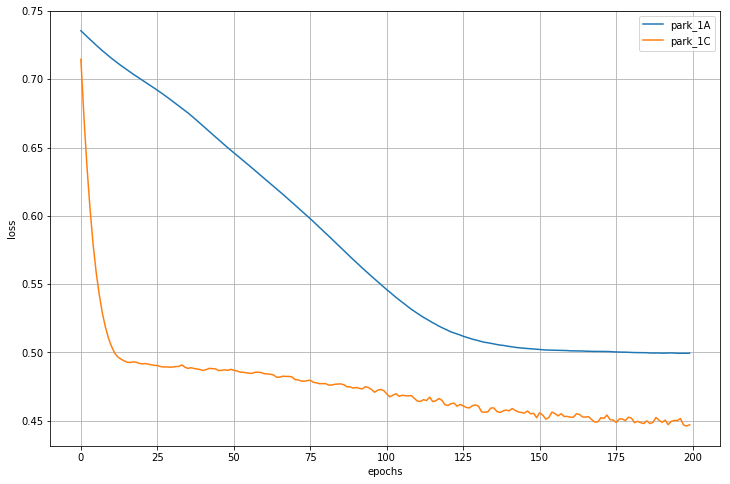

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

### Control subject classifier

In [52]:
disease = 'control'

In [53]:
Y_train_control = redefine_labels(Y_train, 0)
Y_dev_control = redefine_labels(Y_dev, 0)

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 1ms/step - loss: 0.6216 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5865 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/200
833/833 [==============================] - 0s 112us/step - loss: 0.6182 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5838 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/200
833/833 [==============================] - 0s 120us/step - loss: 0.6149 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5813 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/200
833/833 [==============================] - 0s 117us/step - loss: 0.6118 - acc: 0.7371 - precisi

Epoch 30/200
833/833 [==============================] - 0s 109us/step - loss: 0.5713 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5484 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 31/200
833/833 [==============================] - 0s 73us/step - loss: 0.5705 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5478 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 32/200
833/833 [==============================] - 0s 70us/step - loss: 0.5698 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5473 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 75us/step - loss: 0.5691 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sc

Epoch 59/200
833/833 [==============================] - 0s 124us/step - loss: 0.5556 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5359 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 60/200
833/833 [==============================] - 0s 112us/step - loss: 0.5552 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5355 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 61/200
833/833 [==============================] - 0s 120us/step - loss: 0.5548 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5352 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 62/200
833/833 [==============================] - 0s 106us/step - loss: 0.5544 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 88/200
833/833 [==============================] - 0s 108us/step - loss: 0.5458 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5266 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 89/200
833/833 [==============================] - 0s 102us/step - loss: 0.5455 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5263 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 90/200
833/833 [==============================] - 0s 108us/step - loss: 0.5452 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5260 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 91/200
833/833 [==============================] - 0s 117us/step - loss: 0.5449 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 117/200
833/833 [==============================] - 0s 111us/step - loss: 0.5378 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5184 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 118/200
833/833 [==============================] - 0s 107us/step - loss: 0.5376 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5181 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 119/200
833/833 [==============================] - 0s 108us/step - loss: 0.5374 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5179 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 120/200
833/833 [==============================] - 0s 109us/step - loss: 0.5372 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 

Epoch 146/200
833/833 [==============================] - 0s 120us/step - loss: 0.5315 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5117 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 147/200
833/833 [==============================] - 0s 110us/step - loss: 0.5313 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5115 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 148/200
833/833 [==============================] - 0s 115us/step - loss: 0.5311 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5113 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 149/200
833/833 [==============================] - 0s 113us/step - loss: 0.5309 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 

Epoch 175/200
833/833 [==============================] - 0s 111us/step - loss: 0.5256 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5062 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 176/200
833/833 [==============================] - 0s 110us/step - loss: 0.5253 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5060 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 177/200
833/833 [==============================] - 0s 107us/step - loss: 0.5251 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5058 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 178/200
833/833 [==============================] - 0s 111us/step - loss: 0.5249 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 

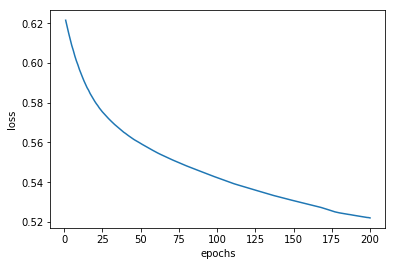

In [54]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_control, X_dev, Y_dev_control)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

Train on 833 samples, validate on 209 samples
Epoch 1/200
833/833 [==============================] - 1s 1ms/step - loss: 0.7436 - acc: 0.2641 - precision: 0.2632 - recall: 1.0000 - f1_score: 0.4164 - val_loss: 0.7298 - val_acc: 0.2488 - val_precision: 0.2452 - val_recall: 1.0000 - val_f1_score: 0.3938
Epoch 2/200
833/833 [==============================] - 0s 93us/step - loss: 0.7113 - acc: 0.3313 - precision: 0.2429 - recall: 0.7471 - f1_score: 0.3540 - val_loss: 0.6960 - val_acc: 0.5550 - val_precision: 0.0837 - val_recall: 0.0779 - val_f1_score: 0.0806
Epoch 3/200
833/833 [==============================] - 0s 107us/step - loss: 0.6812 - acc: 0.6711 - precision: 0.0782 - recall: 0.0360 - f1_score: 0.0483 - val_loss: 0.6666 - val_acc: 0.7273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/200
833/833 [==============================] - 0s 104us/step - loss: 0.6569 - acc: 0.7287 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - 

Epoch 30/200
833/833 [==============================] - 0s 125us/step - loss: 0.5444 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5249 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 31/200
833/833 [==============================] - 0s 121us/step - loss: 0.5434 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5238 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 32/200
833/833 [==============================] - 0s 129us/step - loss: 0.5423 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.5226 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 33/200
833/833 [==============================] - 0s 113us/step - loss: 0.5411 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 59/200
833/833 [==============================] - 0s 107us/step - loss: 0.5085 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4883 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 60/200
833/833 [==============================] - 0s 106us/step - loss: 0.5070 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4869 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 61/200
833/833 [==============================] - 0s 102us/step - loss: 0.5057 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4855 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 62/200
833/833 [==============================] - 0s 104us/step - loss: 0.5043 - acc: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1

Epoch 88/200
833/833 [==============================] - 0s 111us/step - loss: 0.4655 - acc: 0.7383 - precision: 0.1537 - recall: 0.0039 - f1_score: 0.0077 - val_loss: 0.4453 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 89/200
833/833 [==============================] - 0s 112us/step - loss: 0.4642 - acc: 0.7383 - precision: 0.1537 - recall: 0.0045 - f1_score: 0.0088 - val_loss: 0.4437 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 90/200
833/833 [==============================] - 0s 111us/step - loss: 0.4628 - acc: 0.7395 - precision: 0.2317 - recall: 0.0082 - f1_score: 0.0158 - val_loss: 0.4424 - val_acc: 0.7560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 91/200
833/833 [==============================] - 0s 105us/step - loss: 0.4614 - acc: 0.7443 - precision: 0.6927 - recall: 0.0282 - f1_score: 0.0538 - val_loss: 0.4417 - val_acc:

833/833 [==============================] - 0s 105us/step - loss: 0.4297 - acc: 0.7731 - precision: 0.6881 - recall: 0.2396 - f1_score: 0.3485 - val_loss: 0.4110 - val_acc: 0.8038 - val_precision: 0.8212 - val_recall: 0.2549 - val_f1_score: 0.3885
Epoch 120/200
833/833 [==============================] - 0s 106us/step - loss: 0.4286 - acc: 0.7767 - precision: 0.7069 - recall: 0.2634 - f1_score: 0.3827 - val_loss: 0.4103 - val_acc: 0.8134 - val_precision: 0.8151 - val_recall: 0.3138 - val_f1_score: 0.4520
Epoch 121/200
833/833 [==============================] - 0s 113us/step - loss: 0.4276 - acc: 0.7863 - precision: 0.7034 - recall: 0.3144 - f1_score: 0.4321 - val_loss: 0.4094 - val_acc: 0.8134 - val_precision: 0.8151 - val_recall: 0.3138 - val_f1_score: 0.4520
Epoch 122/200
833/833 [==============================] - 0s 112us/step - loss: 0.4267 - acc: 0.7863 - precision: 0.7358 - recall: 0.3078 - f1_score: 0.4225 - val_loss: 0.4085 - val_acc: 0.8086 - val_precision: 0.7990 - val_recall: 

833/833 [==============================] - 0s 105us/step - loss: 0.4051 - acc: 0.8139 - precision: 0.7345 - recall: 0.4615 - f1_score: 0.5571 - val_loss: 0.3897 - val_acc: 0.8325 - val_precision: 0.8400 - val_recall: 0.3925 - val_f1_score: 0.5347
Epoch 151/200
833/833 [==============================] - 0s 108us/step - loss: 0.4046 - acc: 0.8163 - precision: 0.7286 - recall: 0.4827 - f1_score: 0.5765 - val_loss: 0.3892 - val_acc: 0.8325 - val_precision: 0.7943 - val_recall: 0.4316 - val_f1_score: 0.5586
Epoch 152/200
833/833 [==============================] - 0s 118us/step - loss: 0.4041 - acc: 0.8139 - precision: 0.7234 - recall: 0.4613 - f1_score: 0.5594 - val_loss: 0.3886 - val_acc: 0.8325 - val_precision: 0.8400 - val_recall: 0.3925 - val_f1_score: 0.5347
Epoch 153/200
833/833 [==============================] - 0s 97us/step - loss: 0.4033 - acc: 0.8187 - precision: 0.7333 - recall: 0.4894 - f1_score: 0.5820 - val_loss: 0.3881 - val_acc: 0.8373 - val_precision: 0.7988 - val_recall: 0

833/833 [==============================] - 0s 116us/step - loss: 0.3858 - acc: 0.8211 - precision: 0.7062 - recall: 0.5495 - f1_score: 0.6128 - val_loss: 0.3738 - val_acc: 0.8278 - val_precision: 0.7809 - val_recall: 0.4514 - val_f1_score: 0.5681
Epoch 182/200
833/833 [==============================] - 0s 116us/step - loss: 0.3852 - acc: 0.8211 - precision: 0.7085 - recall: 0.5393 - f1_score: 0.6094 - val_loss: 0.3734 - val_acc: 0.8278 - val_precision: 0.7809 - val_recall: 0.4514 - val_f1_score: 0.5681
Epoch 183/200
833/833 [==============================] - 0s 116us/step - loss: 0.3853 - acc: 0.8223 - precision: 0.7269 - recall: 0.5367 - f1_score: 0.6112 - val_loss: 0.3730 - val_acc: 0.8278 - val_precision: 0.7809 - val_recall: 0.4514 - val_f1_score: 0.5681
Epoch 184/200
833/833 [==============================] - 0s 116us/step - loss: 0.3840 - acc: 0.8247 - precision: 0.7209 - recall: 0.5601 - f1_score: 0.6268 - val_loss: 0.3726 - val_acc: 0.8421 - val_precision: 0.7937 - val_recall: 

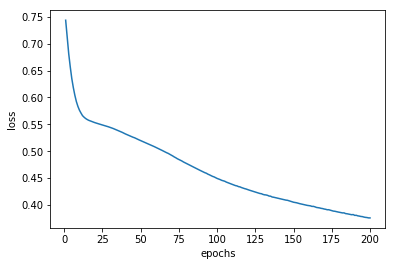

In [55]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_control, X_dev, Y_dev_control)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1c = history.history

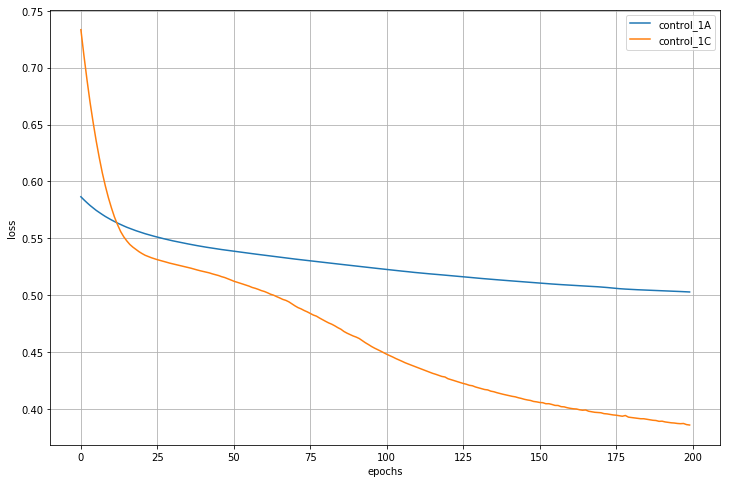

In [56]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

***
**To do**:
* Save model, history and hyperparameters in one single file
* Compare other metrics (f1 score, ...) between  architectures for every disease
***